In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

C:\Program Files\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Program Files\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Program Files\Python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


''

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
cd "/content/gdrive/MyDrive/Colab Notebooks/"

/content/gdrive/MyDrive/Colab Notebooks


In [35]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks'

In [36]:
!unzip yelp_labelled.zip

Archive:  yelp_labelled.zip
replace yelp_labelled.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: yelp_labelled.txt       


In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv("yelp_labelled.txt", sep='\t', names=['sentence', 'label'])

data.head() # 1000条数据

# 数据 X 和 标签 y
sentence = data['sentence'].values
label = data['label'].values

# 训练集 测试集拆分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentence, label, test_size=0.2, random_state=1)

In [3]:
max_features = 2000

# 文本向量化
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train) # 训练tokenizer
X_train = tokenizer.texts_to_sequences(X_train) # 转成 [[ids...],[ids...],...]
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index)+1 # +1 是因为index 0, 0 不对应任何词，用来pad

maxlen = 50
# pad 保证每个句子的长度相等
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
# post 尾部补0，pre 前部补0
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 256)           512000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               164352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 676,481
Trainable params: 676,481
Non-trainable params: 0
_________________________________________________________________


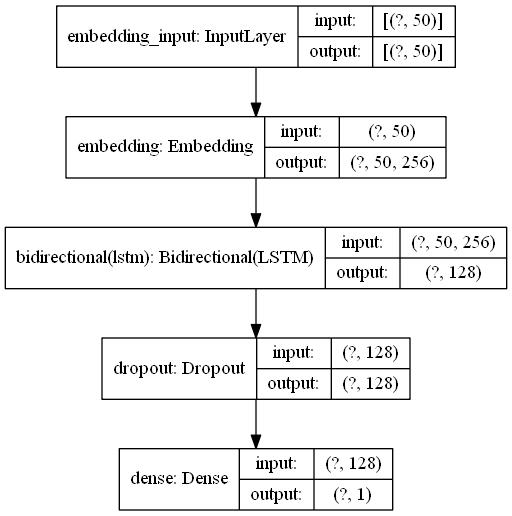

In [4]:
embed_dim = 256
hidden_units = 64

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
model = Sequential()
model.add(Embedding(input_dim=max_features,output_dim=embed_dim,
                    input_length=maxlen))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # 二分类sigmoid, 多分类 softmax

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.jpg') # 绘制模型结构到文件

Epoch 1/100
12/12 - 1s - loss: 0.6953 - accuracy: 0.5042 - val_loss: 0.6846 - val_accuracy: 0.5250
Epoch 2/100
12/12 - 1s - loss: 0.6668 - accuracy: 0.6944 - val_loss: 0.6749 - val_accuracy: 0.6000
Epoch 3/100
12/12 - 1s - loss: 0.5820 - accuracy: 0.7903 - val_loss: 0.6104 - val_accuracy: 0.7250
Epoch 4/100
12/12 - 1s - loss: 0.4111 - accuracy: 0.8708 - val_loss: 0.4811 - val_accuracy: 0.7750
Epoch 5/100
12/12 - 1s - loss: 0.2297 - accuracy: 0.9458 - val_loss: 0.5811 - val_accuracy: 0.7375
Epoch 6/100
12/12 - 1s - loss: 0.1394 - accuracy: 0.9708 - val_loss: 0.4916 - val_accuracy: 0.7625
Epoch 7/100
12/12 - 1s - loss: 0.0863 - accuracy: 0.9861 - val_loss: 0.4903 - val_accuracy: 0.8375
Epoch 8/100
12/12 - 1s - loss: 0.0456 - accuracy: 0.9944 - val_loss: 0.5602 - val_accuracy: 0.8250
Epoch 9/100
12/12 - 1s - loss: 0.0264 - accuracy: 0.9972 - val_loss: 0.6344 - val_accuracy: 0.8125
Epoch 10/100
12/12 - 1s - loss: 0.0219 - accuracy: 0.9986 - val_loss: 0.6534 - val_accuracy: 0.8125
Epoch 11/

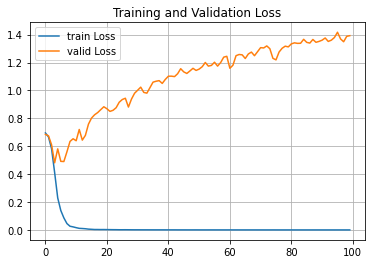

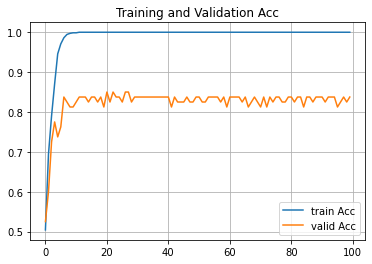

In [5]:
history = model.fit(X_train,y_train,batch_size=64,
             epochs=100,verbose=2,validation_split=0.1)
# verbose 是否显示日志信息，0不显示，1显示进度条，2不显示进度条
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print("训练集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("测试集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))

# 绘制训练曲线
from matplotlib import pyplot as plt
import pandas as pd
his = pd.DataFrame(history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(loss, label='train Loss')
plt.plot(val_loss, label='valid Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(acc, label='train Acc')
plt.plot(val_acc, label='valid Acc')
plt.title('Training and Validation Acc')
plt.legend()
plt.grid()
plt.show()

In [8]:
model.save('trained_model.h5')

import pickle
with open('trained_tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer, f)

# 下载到本地
# from google.colab import files
# files.download('trained_model.h5')
# files.download('trained_tokenizer.pkl')